## Hee Won Ahn

__Exercise 1__

Answer the following questions by querying [Lahman Baseball Database](http://seanlahman.com/). The 2019 version together with the description (`readme2019.txt`) are on Piazza. Answer the following questions. 

The purpose of this assignment is to practice accessing and analyzing data in a database. For full credit for (a) and (b), query the correct table with `pandas.read_sql` and a single SQL query. Unless otherwise specified, return in the same format of the test case. 

In [1]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
db = sql.connect("lahmansbaseballdb.sqlite")

__(a, i)__ Which pitcher has the second most [home runs allowed](https://en.wikipedia.org/wiki/Home_runs_allowed) in the American League? __(ii)__ Which pitcher has the worst home runs allowed per game ratio? 

In [3]:
#(a,i) most home runs allowed in the American League: 
result = pd.read_sql("""SELECT p.playerID,sum(p.HR) as total_allowed, peo.nameFirst, peo.nameLast
                        FROM pitching AS p 
                        JOIN people AS peo ON p.playerID=peo.playerID  
                        WHERE lgID='AL'
                        GROUP BY p.playerID 
                        ORDER BY total_allowed DESC
                        LIMIT 1
                        OFFSET 1
                        """,db).squeeze()
result
# Solution
print(result['nameFirst'] + " " + result['nameLast'] + " "+"has the second most home runs allowed in the American League by",str(result['total_allowed']))

Tim Wakefield has the second most home runs allowed in the American League by 401


In [4]:
#(a,ii) worst home runs allowed per game ratio
result = pd.read_sql("""SELECT p.playerID,sum(p.HR)/sum(p.G) as allowed_per_ratio, peo.nameFirst, peo.nameLast
                        FROM pitching AS p 
                        JOIN people AS peo ON p.playerID=peo.playerID 
                        GROUP BY p.playerID
                        ORDER BY allowed_per_ratio DESC
                        LIMIT 1
                        """,db).squeeze()
# Solution
print(result['nameFirst'] + " " + result['nameLast'] + " "+"has worst home runs allowed per game ratio by "+ str(result['allowed_per_ratio']))

Larry Biittner has worst home runs allowed per game ratio by 3


__(b, i)__ Amongst all players in the American League that have passed, report their average lifespan in full years. __(ii)__ Return the six schools with most hall-of-fame alumni. __(iii)__ What fraction of managers have not been professional players?  

In [5]:
#(b,i) average lifespan for passed players in the National League
result = pd.read_sql("""SELECT avg(death_date-birth_date) as average_lifespan
                        FROM people 
                        WHERE playerID IN (SELECT playerID FROM Appearances WHERE lgID = 'AL') AND death_date IS NOT Null                   
                        """,db).squeeze()
# Solution
print("Average lifespan in full years is",round(result),"years")

Average lifespan in full years is 70 years


In [6]:
#(b,ii) six schools with most hall-of-fame alumni
result = pd.read_sql("""SELECT s.schoolID, count(playerID) as number_of_player
                        FROM schools s
                        JOIN collegeplaying c
                        ON s.schoolID=c.schoolID
                        WHERE c.playerID IN (SELECT playerID FROM HallOfFame)
                        GROUP BY s.schoolID
                        ORDER BY number_of_player DESC
                        LIMIT 6
                        """,db).squeeze()
# Solution
print("Six schools with most hall-of-fame alumni:")
for i in result['schoolID']:
    print("SchoolID:",i)

Six schools with most hall-of-fame alumni:
SchoolID: usc
SchoolID: arizonast
SchoolID: michigan
SchoolID: ucla
SchoolID: okstate
SchoolID: missst


In [7]:
#(b,iii)fraction of managers have not been professional players?
result = pd.read_sql("""
                        SELECT AVG(plyrMgr = 'N') as fraction_not_players
                        FROM Managers
                        """,db).squeeze()
# Solution
print('fraction of managers have not been professional players is',result)

fraction of managers have not been professional players is 0.8175904977375565


__(c)__ Create a world map with a color gradient corresponding to the log-number of players per country in the data set. Use `pandas.read_html` to retrieve the ISO codes from [wikipedia](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes), and merge those records as good as you can. Match no more than ten countries to their ISOs manually. 

In [8]:
#(c)
result = pd.read_sql("""SELECT birthcountry, count(*) AS player_count
                        FROM people
                        GROUP BY birthcountry
                        """,db).squeeze()
result['log_player_count'] = np.log1p(result['player_count'])
iso_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"
iso_df_list = pd.read_html(iso_url)
iso_df = iso_df_list[0] 
iso_df.columns = ['Country name', 'Official state name per the World Factbook', 'Sovereignty','A-2','A-3','N.C.','ISO 3166-2','TLD']
select=['Country name','A-3']
iso_df=iso_df[select]

In [9]:
#(c)
#changing some name of countries to merge data set. 
iso_df['Country name'].replace({'Australia [c]': 'Australia', 'Bahamas (the)': 'Bahamas',
                              'Canada':'CAN','Curaçao':'Curacao','Czechia [j]':'Czech Republic',
                                'Dominican Republic (the)':'D.R.','France [m]':'France',
                               'Netherlands, Kingdom of the':'Netherlands','Puerto Rico':'P.R.',
                               'Philippines (the)':'Philippines','Russian Federation (the) [w]':'Russia',
                               'Korea (the Republic of) [q]':'South Korea',
                               'Taiwan (Province of China) [z]':'Taiwan','United States of America (the)':'USA',
                               'United Kingdom of Great Britain and Northern Ireland (the)':'United Kingdom',
                               'Virgin Islands (U.S.) [ai]':'V.I.',
                               'Venezuela (Bolivarian Republic of)':'Venezuela','Viet Nam [ag]':'Viet Nam'} ,inplace=True)

/var/folders/3v/lhv9vlyj6192ss8g534c279r0000gn/T/ipykernel_1282/1130472945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iso_df['Country name'].replace({'Australia [c]': 'Australia', 'Bahamas (the)': 'Bahamas',


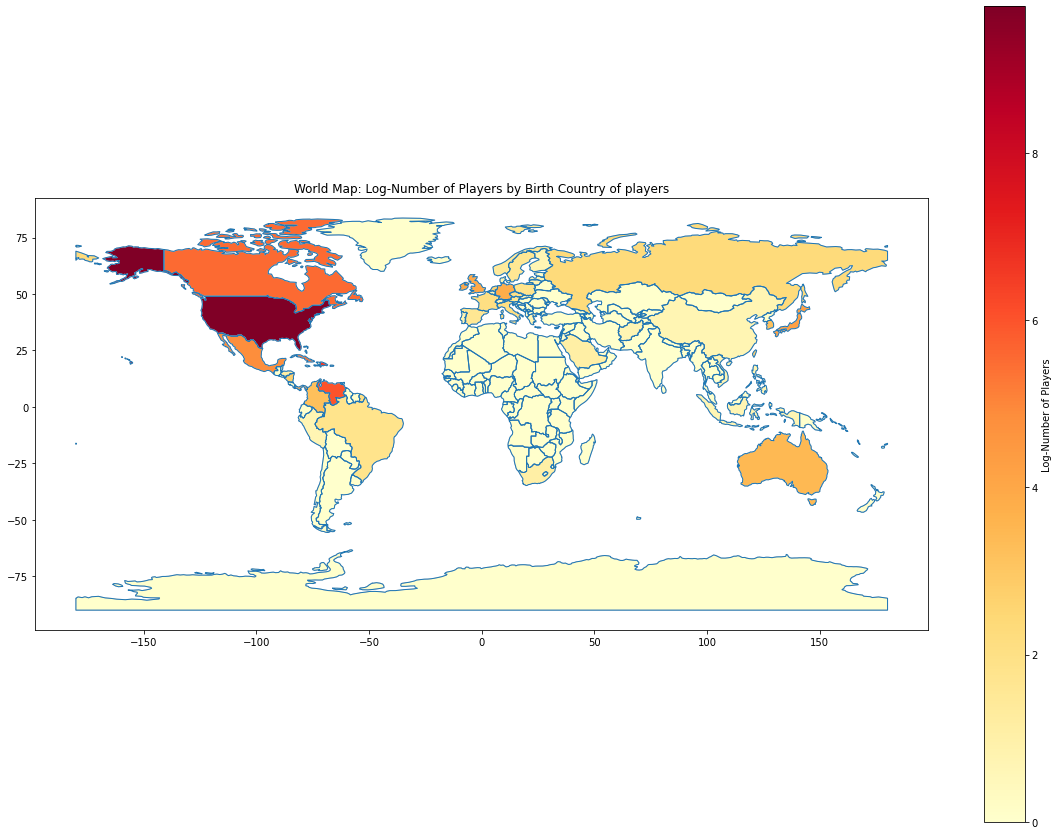

In [10]:
#(c) 
merged_df = pd.merge(result, iso_df, how='left', left_on='birthCountry', right_on='Country name')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = pd.merge(world, merged_df, left_on='iso_a3', right_on='A-3', how='left')
world['log_player_count'] = world['log_player_count'].fillna(0)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
# Solution
world.boundary.plot(ax=ax, linewidth=1) 
world.plot(column='log_player_count', ax=ax, legend=True, legend_kwds={'label': "Log-Number of Players"}, cmap='YlOrRd', edgecolor='0.8')
plt.title('World Map: Log-Number of Players by Birth Country of players')
plt.show()


__Exercise 2__

We will use the [lichess](https://lichess.org/api) API to retrieve some information about the current state of chess in the world. In order to answer below questions, make precise and economical requests. You may use:
```
import requests
import json
import pandas

from datetime import datetime
```

In [11]:
import requests
import json
import pandas
from datetime import datetime
import re

__(a)__ What is the real name of the leader of the blitz leaderboard? 

In [12]:
#(a) real name of the leader of the blitz leaderboard
url="https://lichess.org/api/player/top/1/blitz"
response = requests.get(url)
data = response.json()
username=data['users'][0]['username']
url=f"https://lichess.org/api/user/{username}"
response = requests.get(url)
data = response.json()
firstname=data['profile']['firstName']
lastname=data['profile']['lastName']
# Solution
print('real name of the leader of the blitz leaderboard is', firstname,lastname)

real name of the leader of the blitz leaderboard is Vladislav Artemiev


__(b, i)__ Get the username of the last player that played a rapid game against user `athena-pallada`. __(ii)__ In all games against this user, how many times did `athena-pallada` win? _(Provide code that answers the question in case more than just a single game is returned)_

In [13]:
#(b,i) username of the last player that played a rapid game against user athena-pallada
username = "athena-pallada"
url = f"https://lichess.org/api/games/user/{username}"
response = requests.get(url, params = {
        "perfType": "rapid", 
        "max":1,
        "moves":"False"
    })
data=response.text.split('\n')
last_username=data[4][8:16]
# Solution
print('username of the last player that played a rapid game against user athena-pallada is', last_username)

username of the last player that played a rapid game against user athena-pallada is Bacio129


In [14]:
#(b,ii) times athena-pallada won
username = "athena-pallada"
url = f"https://lichess.org/api/games/user/{username}"
response = requests.get(url, params = {
        "vs": str(last_username), 
        "moves":"False"
    })
game_result=response.text.split('\n')
wins = sum('Result "1-0"' in result for result in game_result)
# Solution
print('athena-palla won', wins, 'times')

athena-palla won 2 times


__(c)__ Consider the top ten players in the bullet leaderboard. __(i)__ Which player has the most bullet games overall? __(ii)__ Which player has played the most bullet games relative to account age in days? __(iii)__ Which player has the worst win-to-loss ratio over all formats?

In [15]:
#(c,i) player has the most bullet games overall
response = requests.get("https://lichess.org/api/player")
data=response.json()
bullet_user=[]
for i in range(0,9):
    bullet_user.append(data['bullet'][i]['username'])
total_game=[]
for i in range(0,9):
    url = f"https://lichess.org/api/user/{bullet_user[i]}/perf/bullet"
    response = requests.get(url)
    data=response.json()
    total_game.append(data['stat']['count']['all'])
most_bullet=bullet_user[total_game.index(max(total_game))]
# Solution
print(most_bullet, 'has the most bullet games overall')

Mishka_The_Great has the most bullet games overall


In [16]:
#(c,ii) played the most bullet games relative to account age in days
age_days=[]
for i in range(0,9):
    url = f"https://lichess.org/api/user/{bullet_user[i]}"
    response = requests.get(url)
    data=response.json()
    created_at_seconds=data['createdAt']/1000
    current_time_seconds = datetime.now().timestamp()
    account_age_seconds = current_time_seconds - created_at_seconds
    account_age_days = account_age_seconds / (60 * 60 * 24)
    age_days.append(account_age_days)
games_age=[total_game[i]/age_days[i] for i in range(0,9)]
most_games_age=bullet_user[games_age.index(max(games_age))]
# Solution
print(most_games_age,"has played the most bullet games relative to account age in days")

Mishka_The_Great has played the most bullet games relative to account age in days


In [17]:
#(c,iii)  player has the worst win-to-loss ratio over all formats
ratio=[]
for i in range(0,9):
    url = f"https://lichess.org/api/user/{bullet_user[i]}"
    response = requests.get(url)
    data=response.json()
    ratio.append(data['count']['win']/data['count']['loss'])
min_win_loss=bullet_user[ratio.index(min(ratio))]
# Solution
print(min_win_loss,"has the worst win-to-loss ratio over all formats")

klari64 has the worst win-to-loss ratio over all formats


__(d)__ Get all games from user `manwithavan`. Group them by opening and print the ten most popular. 

In [ ]:
#(d)
response = requests.get("https://lichess.org/api/games/user/manwithavan",
                       params={'opening':'True'})
openings = re.findall(r"\[Opening \"(.*?)\"\]", response.text)
openings_series = pd.Series(openings)
ten_openings = openings_series.value_counts().head(10)
# Solution
print('Ten most popular openings are')
print(ten_openings)

Ten most popular openings are
Van't Kruijs Opening                                 7
Nimzo-Larsen Attack: Modern Variation                7
Mieses Opening                                       6
Pirc Defense                                         6
Zukertort Opening: Kingside Fianchetto               5
Caro-Kann Defense: Breyer Variation                  5
?                                                    5
Nimzo-Larsen Attack                                  5
Zukertort Opening: Queenside Fianchetto Variation    5
Queen's Pawn Game                                    5
dtype: int64
